In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import time

import fun1
import noniid

2022-10-11 15:26:51.947217: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-11 15:26:51.952832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 15:26:51.952855: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path = '/home/ai03/_kunyi/pro_shae/datasets/aki_prediction_m4_m3_eicu/'
input_folder = '6tw_6ts_6pre_v1/'
input_dir = path+input_folder

In [3]:
sig_p = 0.05
k = 5
sampling_value_ls = list(range(100, 0, -10))

In [4]:
def plot_non_iid(d1, d2, d3, plot_d1):
    start_time = time.time()
    
    df_d1 = pd.read_csv(
        input_dir+"6hr_{}_commonFs.csv".format(d1))

    df_d2 = pd.read_csv(
        input_dir+"6hr_{}_commonFs.csv".format(d2))

    df_d3 = pd.read_csv(
        input_dir +"6hr_{}_commonFs.csv".format(d3))

    df_cols = df_d1.columns.tolist()
    cat_f_ls = df_cols[4:6]
    con_f_ls = df_cols[6:]

    for i in cat_f_ls:
        df_d1[i] = df_d1[i].astype('category').cat.codes
        df_d2[i] = df_d2[i].astype('category').cat.codes
        df_d3[i] = df_d3[i].astype('category').cat.codes

    noniid_ls_trans_ls = []
    y_value_ls = []

    for s_v in sampling_value_ls:
        s_v2 = s_v*0.01
        noniid_ls = []   
        for r_i in range(0, k):

            df2_d1 = df_d1.sample(frac=s_v2, replace=False)
            df2_d2 = df_d2.sample(frac=s_v2, replace=False)
            df2_d3 = df_d3.sample(frac=s_v2, replace=False)
            df_d1d2 = pd.concat([df2_d1, df2_d2])
            df_d1d3 = pd.concat([df2_d1, df2_d3])  

            all_dfs = [df2_d1, df2_d2, df2_d3, df_d1d2, df_d1d3] 
            each_round_noniid_ls = []
            y_value_ls.append(s_v)

            for each_df in all_dfs:
                df_noniid = noniid.non_iid_degree(
                    sig_p, df2_d1, each_df, con_f_ls, cat_f_ls)
                each_round_noniid_ls.append(df_noniid)

            noniid_ls.append(each_round_noniid_ls)

        noniid_ls_trans = np.array(noniid_ls).T
        noniid_ls_trans_ls.append(noniid_ls_trans)

    temp_ls = noniid_ls_trans_ls
    all_dfs_ls = []

    for df_i in range(0, len(all_dfs)):
        one_df_temp_ls = []

        for ls_i in range(0, len(sampling_value_ls)):
            one_df_temp_ls.append(temp_ls[ls_i][df_i])
            one_df_temp_ls_1d = np.concatenate(one_df_temp_ls)

        all_dfs_ls.append(one_df_temp_ls_1d)

    ax = plt.gca()
    ax.set_ylim([0, 105])
    ax.set_xlim([-0.05, 1.05])
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 101, 10))

    plt.plot(all_dfs_ls[0], y_value_ls, 
             'ko', label='{}'.format(d1))
    plt.plot(all_dfs_ls[1], y_value_ls, 
             'ro', label='{}'.format(d2))
    plt.plot(all_dfs_ls[2], y_value_ls, 
             'yo', label='{}'.format(d3))
#     plt.plot(all_dfs_ls[3], y_value_ls, 
#              'co', label='{} + {}'.format(d1, d2))
#     plt.plot(all_dfs_ls[4], y_value_ls, 
#              'go', label='{} + {}'.format(d1, d3))
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

    end_time = time.time()
    elapsed_imte = (end_time - start_time)/60
    
    t_str1 = 'Our Method: {} Dataset\n '.format(plot_d1)
    plt.title(t_str1+'(computational time {:0.1f} min.): \n predicts next 6hr. AKI'.format(
        elapsed_imte), fontsize=15) 
    plt.ylabel('Data Sampling Percentage', fontsize=15)
    plt.xlabel('Non-IID Degree', fontsize=15)
    plt.savefig("QM1_{}_pre6hr".format(plot_d1), 
                bbox_inches='tight')
    plt.show()
    return all_dfs_ls, y_value_ls, elapsed_imte

In [5]:
def get_df(d1, d2, d3, m3_all_dfs_ls, m3_y_value_ls, elapsed_imte):
    x, y = '_x', '_y'
    df_ts1 = pd.DataFrame(columns=[d1+x, d1+y, d2+x, 
                                   d2+y, d3+x, d3+y])
    df_ts2 = df_ts1.copy()
    for xi, li in zip(range(0, 5, 2), range(0,3)):
        df_ts2[df_ts2.columns.tolist()[xi]] = m3_all_dfs_ls[li]
        df_ts2[df_ts2.columns.tolist()[xi+1]] = m3_y_value_ls
    df_ts2.to_csv("M1_{}_time_{:0.1f}_non_iid.csv".format(
        d1, elapsed_imte), index=False)   
    return df_ts2

In [6]:
def get_df2(d1, d2, d3, m3_all_dfs_ls, m3_y_value_ls, elapsed_imte):
    x, y = '_x', '_y'
    df_ts1 = pd.DataFrame(columns=[d1+x, d1+y, 
                                   d2+x, d2+y, 
                                   d3+x, d3+y, 
                                   d1+'+'+d2+x, d1+'+'+d2+y, 
                                   d1+'+'+d3+x, d1+'+'+d3+y])
    df_ts2 = df_ts1.copy()
    for xi, li in zip(range(0, 9, 2), range(0,5)):
        df_ts2[df_ts2.columns.tolist()[xi]] = m3_all_dfs_ls[li]
        df_ts2[df_ts2.columns.tolist()[xi+1]] = m3_y_value_ls
    df_ts2.to_csv("M1_{}_time_{:0.1f}_non_iid_fig4.csv".format(
        d1, elapsed_imte), index=False)   
    return df_ts2

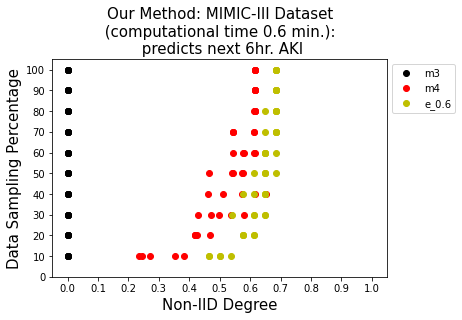

In [6]:
d1 = 'm3'
d2 = 'm4'
d3 = 'e_0.6'
plot_d1 = 'MIMIC-III'
m3_all_dfs_ls, m3_y_value_ls, m3_t = plot_non_iid(d1, d2, d3, plot_d1)

In [7]:
m3_df = get_df(d1, d2, d3, 
               m3_all_dfs_ls, m3_y_value_ls, m3_t)
m3_df.head()

,m3_x,m3_y,m4_x,m4_y,e_0.6_x,e_0.6_y
0,0.0,100,0.614751,100,0.685107,100
1,0.0,100,0.614751,100,0.685107,100
2,0.0,100,0.614751,100,0.685107,100
3,0.0,100,0.614751,100,0.685107,100
4,0.0,100,0.614751,100,0.685107,100


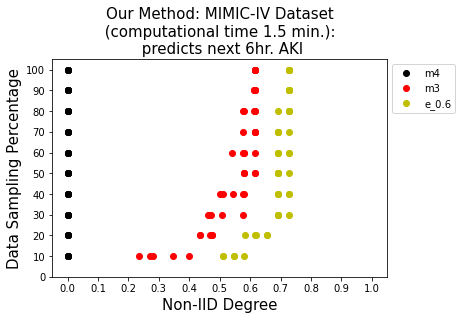

In [9]:
d1 = 'm4'
d2 = 'm3'
d3 = 'e_0.6'
plot_d1 = 'MIMIC-IV'
m4_all_dfs_ls, m4_y_value_ls, m4_t = plot_non_iid(d1, d2, d3, plot_d1)

In [10]:
m4_df = get_df(d1, d2, d3, 
               m4_all_dfs_ls, m4_y_value_ls, m4_t)
m4_df.head()

,m4_x,m4_y,m3_x,m3_y,e_0.6_x,e_0.6_y
0,0.0,100,0.614751,100,0.727494,100
1,0.0,100,0.614751,100,0.727494,100
2,0.0,100,0.614751,100,0.727494,100
3,0.0,100,0.614751,100,0.727494,100
4,0.0,100,0.614751,100,0.727494,100


In [11]:
m4_df2 = get_df2(d1, d2, d3, 
                 m4_all_dfs_ls, m4_y_value_ls, m4_t)
m4_df2

,m4_x,m4_y,m3_x,m3_y,e_0.6_x,e_0.6_y,m4+m3_x,m4+m3_y,m4+e_0.6_x,m4+e_0.6_y
0,0.0,100,0.614751,100,0.727494,100,0.392368,100,0.691058,100
1,0.0,100,0.614751,100,0.727494,100,0.392368,100,0.691058,100
2,0.0,100,0.614751,100,0.727494,100,0.392368,100,0.691058,100
3,0.0,100,0.614751,100,0.727494,100,0.392368,100,0.691058,100
4,0.0,100,0.614751,100,0.727494,100,0.392368,100,0.691058,100
5,0.0,90,0.615533,90,0.727327,90,0.428794,90,0.691073,90
6,0.0,90,0.613799,90,0.727546,90,0.392274,90,0.691223,90
7,0.0,90,0.616056,90,0.727315,90,0.392384,90,0.690844,90
8,0.0,90,0.614960,90,0.727323,90,0.392318,90,0.690946,90
9,0.0,90,0.613960,90,0.727575,90,0.392279,90,0.691090,90


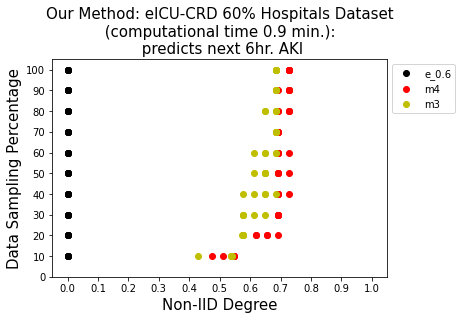

In [10]:
d1 = 'e_0.6'
d2 = 'm4'
d3 = 'm3'
plot_d1 = 'eICU-CRD 60% Hospitals'
e_all_dfs_ls, e_y_value_ls, e_t = plot_non_iid(d1, d2, d3, plot_d1)

In [11]:
e_df = get_df(d1, d2, d3, 
              e_all_dfs_ls, e_y_value_ls, e_t)
e_df.head()

,e_0.6_x,e_0.6_y,m4_x,m4_y,m3_x,m3_y
0,0.0,100,0.727494,100,0.685107,100
1,0.0,100,0.727494,100,0.685107,100
2,0.0,100,0.727494,100,0.685107,100
3,0.0,100,0.727494,100,0.685107,100
4,0.0,100,0.727494,100,0.685107,100
